In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, cv2, struct

caffe_root = '/home/heyanguang/caffecode/caffe/'
sys.path.insert(0, caffe_root + 'python')
os.chdir(caffe_root)
import caffe

if not os.path.isfile(caffe_root + 'examples/mnist/lenet_iter_10000.caffemodel'):
    print("caffemodel is not exist...")
    
caffe.set_mode_gpu()
net = caffe.Net(caffe_root + 'examples/mnist/lenet.prototxt',
                caffe_root + 'examples/mnist/lenet_iter_10000.caffemodel',
                caffe.TEST)

# print net.blobs['data'].data.shape

# im = caffe.io.load_image('examples/images/cat_gray.jpg')

# # res = caffe.io.resize_image(im, (32, 32))
# res = cv2.resize(im, (32, 32), interpolation = cv2.INTER_CUBIC)
# # plt.rcParams['image.cmap'] = 'gray'
# plt.figure()
# plt.imshow(res)
# plt.axis('off')
# print 'res', res.shape
# plt.show()


def readfile():
#     with open('data/mnist/train-images-idx3-ubyte', 'rb') as f1:
#         buf1 = f1.read()
#     with open('data/mnist/train-labels-idx1-ubyte', 'rb') as f2:
#         buf2 = f2.read()
#     return buf1, buf2
    with open('data/mnist/t10k-images-idx3-ubyte', 'rb') as f1:
        buf1 = f1.read()
    with open('data/mnist/t10k-labels-idx1-ubyte', 'rb') as f2:
        buf2 = f2.read()
    return buf1, buf2


def get_image(buf1, read_count, start_location):
    # I means unsigned int, need 4 bytes.
    image_offset = struct.calcsize('IIII')
    # Every picture contains 28*28 pixels, each pixel is one unsigned byte, so the offset is 784 * pic_index.
    image_offset += 784 * start_location
    im = []
    for i in range(read_count):
        # Read 784 unsigned bytes using big-endian.
        temp = struct.unpack_from('>784B', buf1, image_offset)
        im.append(np.reshape(temp, (28, 28)))
        image_offset += struct.calcsize('784B')
    return im


def get_label(buf2, read_count, start_location):
    label_offset = struct.calcsize('II')
    label_offset += start_location
    return struct.unpack_from(str(read_count) + 'B', buf2, label_offset)

# plt.rcParams['image.cmap'] = 'gray'
'''Transform multiple picture(2-D array) into one big 2-D array and show it.'''
def show_data(data, head, padsize = 1, padval = 0):
    data = data.astype('float')
    data -= data.min()
    data /= data.max()

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
#     print 'n', n
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
#     print 'padding', padding
#     print 'data.shape0', data.shape
    data = np.pad(data, padding, mode = 'constant', constant_values = (padval, padval))

    # tile the filters into an image
#     print 'data.shape1', data.shape
#     print 'data.shape[1:]', data.shape[1:]
    ndim = data.ndim
    data = data.reshape((n, n) + data.shape[1:])
#     print 'data.shape2', data.shape
#     print 'ndim', ndim

#     print 'kk', (0, 2, 1, 3) + tuple(range(4, ndim + 1)), tuple(range(4, ndim + 1))
    data = data.transpose((0, 2, 1, 3) + tuple(range(4, ndim + 1)))
#     print 'data.shape3', data.shape

#     print 'data.shape[4:]', data.shape[4:]
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
#     print 'data.shape4', data.shape
    plt.figure()
    plt.title(head)
#     plt.imshow(data)
    plt.imshow(data, cmap = 'gray')
    plt.axis('off')


# image_data, label_data = readfile()
# image_offset = struct.calcsize('>IIII')
# temp = struct.unpack_from('>784B', image_data, image_offset)
# im = np.reshape(temp, (28, 28))
# label_offset = 0
# label_offset += struct.calcsize('>II')
# label = struct.unpack_from('>B', label_data, label_offset)

# title = str(label[0])
# plt.title(title)
# plt.imshow(im, cmap = 'gray')
# plt.show()

read_count = 1
start_image_index = 200
image_data, label_data = readfile()
im = get_image(image_data, read_count, start_image_index)
im = np.array(im)
print 'The initial shape of im is: ', im.shape
label = get_label(label_data, read_count, start_image_index)

'''Transform multiple pictures(2-D array) into one big 2-D array and show it.'''
show_data(im, 'origin images')

'''Show each of multiple pictures in a subplot separately.'''
# for i in range(read_count):
#     plt.subplot(np.sqrt(read_count), np.sqrt(read_count), i + 1)
#     title = str(label[i])
#     plt.title(title)
#     plt.imshow(im[i], cmap = 'gray')

# plt.show()
# plt.axis('off')


# transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# transformer.set_transpose('data', (3, 2, 0, 1))
# transformer.set_raw_scale('data', 255)
# transformer.set_channel_swap('data', (1, 0))
# net.blobs['data'].data = transformer.preprocess('data', im)
# im = im.astype('float')
im_input = im[np.newaxis, :, :, :]/float(255)
print 'im_input type: ', im_input.dtype
im_input = im_input.transpose(1, 0, 2, 3)
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[:] = im_input
# print net.blobs['data'].data.shape
print im_input.shape
# net.blobs['data'].data

net.forward()
print net.blobs['prob'].data.shape


# plt.show()




The initial shape of im is:  (1, 28, 28)
im_input type:  float64
(1, 1, 28, 28)
(1, 10)


In [17]:
params = net.params['conv1'][0].data[:, 0, :, :]
pics = net.blobs['conv1'].data[0, :, :, :]
show_data(params, 'conv1 params')
show_data(pics, 'conv1 data')


# plt.show()


In [22]:
pics = net.blobs['pool1'].data[0, :, :, :]
show_data(pics, 'pool1 data')


# plt.show()


In [25]:
params = net.params['conv2'][0].data[:, 0, :, :]
pics = net.blobs['conv2'].data[0, :, :, :]
show_data(params, 'conv2 params')
show_data(pics, 'conv2 data')


# plt.show()


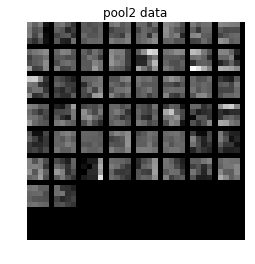

In [29]:
pics = net.blobs['pool2'].data[0, :, :, :]
show_data(pics, 'pool2 data')


plt.show()
